# Open Data in den Bundesministerien

Um die Open-Data-Aktivitäten der Bundesministerien zu analysieren, werden die Metadaten von [GovData](https://www.govdata.de/) analysiert. 

Diese Analyse bietet sich an, da Behörden des Bundes nach § 12a E-Government-Gesetz (EGovG) verpflichtet sind, veröffentlichte Daten mit Metadaten zu versehen und diese im nationalen Metadatenportal GovData einzustellen. 

Die auf GovData eingestellten Metadaten können über SPARQL-Abfragen durchsucht werden. SPARQL ist eine Abfragesprache mit der Daten im RDF-Format (Resource Description Framework) abgerufen und bearbeitet werden können. Auf GovData wird ein [SPARQL-Assisent](https://www.govdata.de/web/guest/sparql-assistent) bereitgestellt, der beispielhafte Abfragen aufführt.  

Für die Reproduzierbarkeit der Analyse wurde die Abfrage jedoch nicht mit dem SPARQL-Assistenten, sondern mit dem unten aufgeführten Skript ausgeführt. Über das Metadatenfeld ```dct:publisher``` und über den regulären Ausdruck ```^bm.*|bundesminist.*|^ausw.*|^aa$|^bundeskanzl.*|^bkamt.*``` wurden die Datensätze der Bundesministerien (+ Bundeskanzleramt) identifiziert. Des Weiteren wurden die Metadatenfelder ```dcat:accessURL``` und ```dct:issued``` abgerufen, um Aussagen über die Verfügbarkeit der Ressourcen, über die Dateiformate und über die zeitliche Entwicklung der Open-Data-Aktivitäten treffen zu können.

In [63]:
# Import python modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import io
import os
from datetime import datetime

In [64]:
# Define the SPARQL endpoint
endpoint = "https://www.govdata.de/sparql"

# Get the proxy URL
proxy_url = requests.utils.getproxies().get('http')

# Set the proxy configuration
proxies = {'http': proxy_url}

query = """
PREFIX foaf: <http://xmlns.com/foaf/0.1/>
PREFIX dcat: <http://www.w3.org/ns/dcat#>
PREFIX dct: <http://purl.org/dc/terms/>
PREFIX dcatde: <http://dcat-ap.de/def/dcatde/>
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>

SELECT ?dataset ?title ?publisher_name ?distribution_link ?publication_year ?license ?format
WHERE {
  ?dataset a dcat:Dataset ;
            dct:title ?title ;
            dcat:distribution ?distribution ;
            dct:publisher ?publisher .
  OPTIONAL {?publisher foaf:name ?publisher_name} .
  FILTER(REGEX(lcase(?publisher_name),'^bm.*|bundesminist.*|^ausw.*|^aa$|^bundeskanzl.*|^bkamt.*')) .
  OPTIONAL { ?distribution dcat:accessURL ?distribution_link } .
  OPTIONAL { ?dataset dct:issued ?publication_date } .
  BIND (year(?publication_date) as ?publication_year) .
  OPTIONAL { ?distribution dct:license ?license } .
  OPTIONAL { ?distribution dct:format ?format }
}
"""

# Send the SPARQL query and get the response in CSV format
url = endpoint + '?query=' + requests.utils.quote(query, safe='')
headers = {'Accept': 'text/csv'}
response = requests.get(url, headers=headers, proxies=proxies, timeout=60)

# Convert the CSV response to a Pandas DataFrame
df = pd.read_csv(io.StringIO(response.content.decode('utf-8')))

# Delete unnecessary variables
del endpoint, proxy_url, proxies, query, url, headers, response

In [65]:
# Use np.select to create a new column publisher_short with the short publisher name
conditions = [
    df['publisher_name'].str.contains('Wirtschaft und|BMWK|BMWI', case=False),
    df['publisher_name'].str.contains('Finanzen|^BMF', case=False),
    df['publisher_name'].str.contains('Innern|^BMI', case=False),
    df['publisher_name'].str.contains('^Ausw|^AA', case=False),
    df['publisher_name'].str.contains('Justitz|BMJ', case=False),
    df['publisher_name'].str.contains('Arbeit|BMAS', case=False),
    df['publisher_name'].str.contains('Verteidigung|BMVg', case=False),
    df['publisher_name'].str.contains('Landwirtschaft|BMEL', case=False),
    df['publisher_name'].str.contains('Familie|BMFSFJ', case=False),
    df['publisher_name'].str.contains('Gesundheit|BMG', case=False),
    df['publisher_name'].str.contains('Verkehr|BMDV', case=False),
    df['publisher_name'].str.contains('Umwelt|BMUV', case=False),
    df['publisher_name'].str.contains('Bildung|BMBF', case=False),
    df['publisher_name'].str.contains('Entwicklung|BMZ', case=False),
    df['publisher_name'].str.contains('Wohnen|BMWSB', case=False),
    df['publisher_name'].str.contains('Bundeskanzleramt|BKAmt', case=False)
]

choices = ['BMWK', 'BMF', 'BMI', 'AA', 'BMJ', 'BMAS', 'BMVg', 'BMEL', 'BMFSFJ', 'BMG', 'BMDV', 'BMUV', 'BMBF', 'BMZ', 'BMWSB', 'BKAmt']
df['publisher_short'] = np.select(conditions, choices, default='other')

# Create factor column for the publisher_short column
df['publisher_short'] = pd.Categorical(df['publisher_short'], categories=choices, ordered=True)

# Move column publisher_short behind publisher_name
df = df[['dataset', 'title', 'publisher_name', 'publisher_short', 'distribution_link', 'publication_year', 'license', 'format']]

# Delete variables that are not needed anymore
del choices, conditions

## Datensätze nach Bundesministerium

In [66]:
# Get only distinct datasets
df_distinct = df.drop_duplicates(subset=['dataset'])

In [67]:
# Count the number of datasets per publisher
df_distinct_publ = df_distinct['publisher_short'].value_counts()

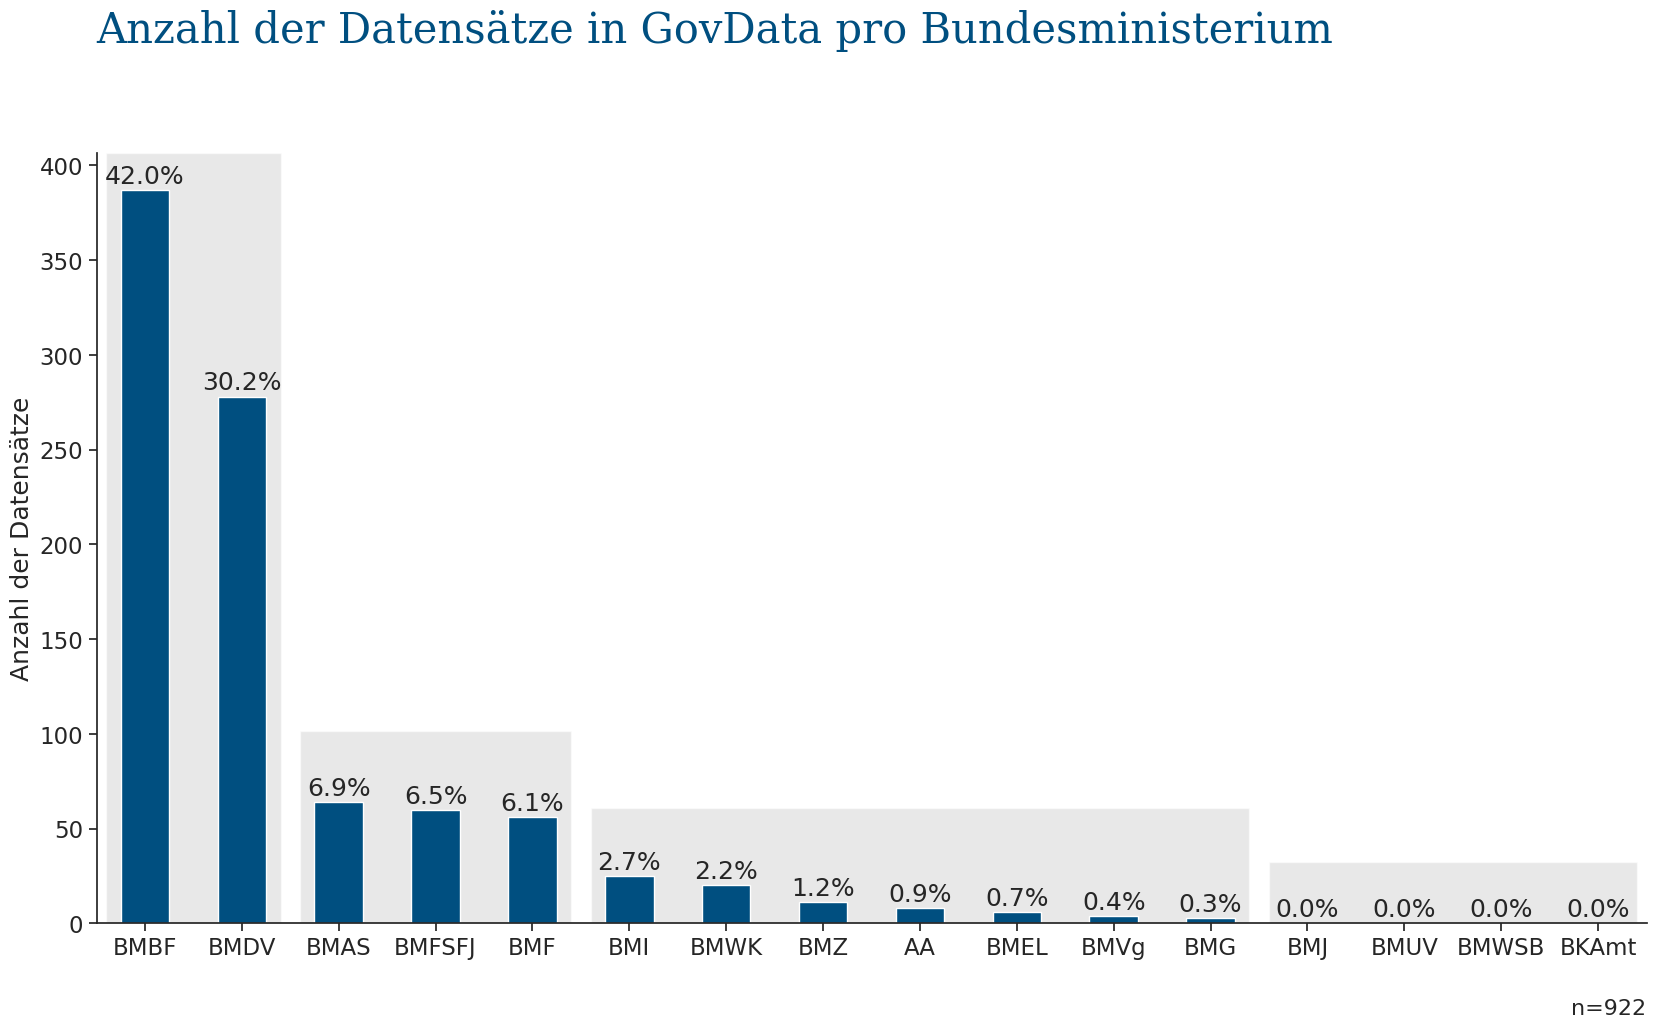

In [68]:
# Plot df_distinct_publ with Seaborn

# Set the font scale
sns.set(font_scale=1.5)

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params, font_scale=1.5)

# Set the color palette
#sns.set_palette("bright")

# Set color of the bars
sns.set_color_codes("pastel")

ax = df_distinct_publ.plot(kind='bar', figsize=(20,10), color='#004F80')

# Set font properties and position of title 
title_font = {'size': 30, 'family': 'serif', 'color': '#004F80'}
ax.set_title("Anzahl der Datensätze in GovData pro Bundesministerium", fontdict=title_font, loc='left', pad=80)

# Set the labels
ax.xaxis.label.set_visible(False)
ax.set_ylabel('Anzahl der Datensätze')

# Set the x-axis labels to horizontal
ax.tick_params(axis='x', labelrotation=0)

# Add the percentages
for p in ax.patches:
    ax.annotate('{:.1f}%'.format(100 * p.get_height() / df_distinct_publ.sum()), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

""" # Add rectangle for the first two BMs behind the bars
for p in ax.patches:
    if p.get_x() < 1.4:
        ax.axvspan(p.get_x(), p.get_x() + p.get_width(), facecolor='lightgrey', alpha=0.5)
    else:
        break """

# Add caption below the plot with n=total number of count
caption = 'n=' + str(df_distinct_publ.sum())
ax.text(1, -0.11, caption, ha='right', va='center', transform=ax.transAxes, fontsize=16)


# Add rectangle for the first two BMs
ax.axvspan(-0.4, 1.4, facecolor='lightgrey', alpha=0.5, zorder=-1)
ax.axvspan(1.6, 4.4, ymax=0.25, facecolor='lightgrey', alpha=0.5, zorder=-1)
ax.axvspan(4.6, 11.4, ymax=0.15, facecolor='lightgrey', alpha=0.5, zorder=-1)
ax.axvspan(11.6, 15.4, ymax=0.08, facecolor='lightgrey', alpha=0.5, zorder=-1)

# Save plot as PNG locally in folder output

# Create folder output if it doesn't exist
if not os.path.exists('output'):
    os.makedirs('output')

# Save plot as PNG
plt.savefig(f'output/{datetime.now().strftime("%Y%m%d")}_Anzahl_BM.png', bbox_inches='tight', dpi=300)

# Show the plot
plt.show()



In [69]:
# Install sparqlwrapper with pip install sparqlwrapper

from SPARQLWrapper import SPARQLWrapper, JSON

sparql = SPARQLWrapper("https://www.govdata.de/sparql")
query = """
PREFIX dcat: <http://www.w3.org/ns/dcat#>
PREFIX dct: <http://purl.org/dc/terms/>
PREFIX foaf: <http://xmlns.com/foaf/0.1/>
SELECT (COUNT(?dataset) AS ?datasets) 
WHERE {
  ?dataset a dcat:Dataset .
  ?dataset dct:publisher ?publisher .
  OPTIONAL {?publisher foaf:name ?publisher_name} .
  FILTER(!REGEX(lcase(?publisher_name),'^bm.*|bundesminist.*|^ausw.*|^aa$|^bundeskanzl.*|^bkamt.*')) 
}
"""
sparql.setQuery(query)
sparql.setReturnFormat(JSON)
results = sparql.query().convert()

# Extract the number of datasets from the JSON response
n_datasets_all = results['results']['bindings'][0]['datasets']['value']
n_datasets_all = int(n_datasets_all)

from SPARQLWrapper import SPARQLWrapper, JSON

sparql = SPARQLWrapper("https://www.govdata.de/sparql")
query = """
PREFIX dcat: <http://www.w3.org/ns/dcat#>
PREFIX dct: <http://purl.org/dc/terms/>
PREFIX foaf: <http://xmlns.com/foaf/0.1/>
SELECT (COUNT(?dataset) AS ?datasets) 
WHERE {
  ?dataset a dcat:Dataset .
  ?dataset dct:publisher ?publisher .
  OPTIONAL {?publisher foaf:name ?publisher_name} .
  FILTER(REGEX(lcase(?publisher_name),'^bm.*|bundesminist.*|^ausw.*|^aa$|^bundeskanzl.*|^bkamt.*')) 
}
"""
sparql.setQuery(query)
sparql.setReturnFormat(JSON)
results = sparql.query().convert()

# Extract the number of datasets from the JSON response as integer
n_datasets_bm = results['results']['bindings'][0]['datasets']['value']
n_datasets_bm = int(n_datasets_bm)

# Calculate the percentage of datasets from BMs
percentage_bm = n_datasets_bm / n_datasets_all *100


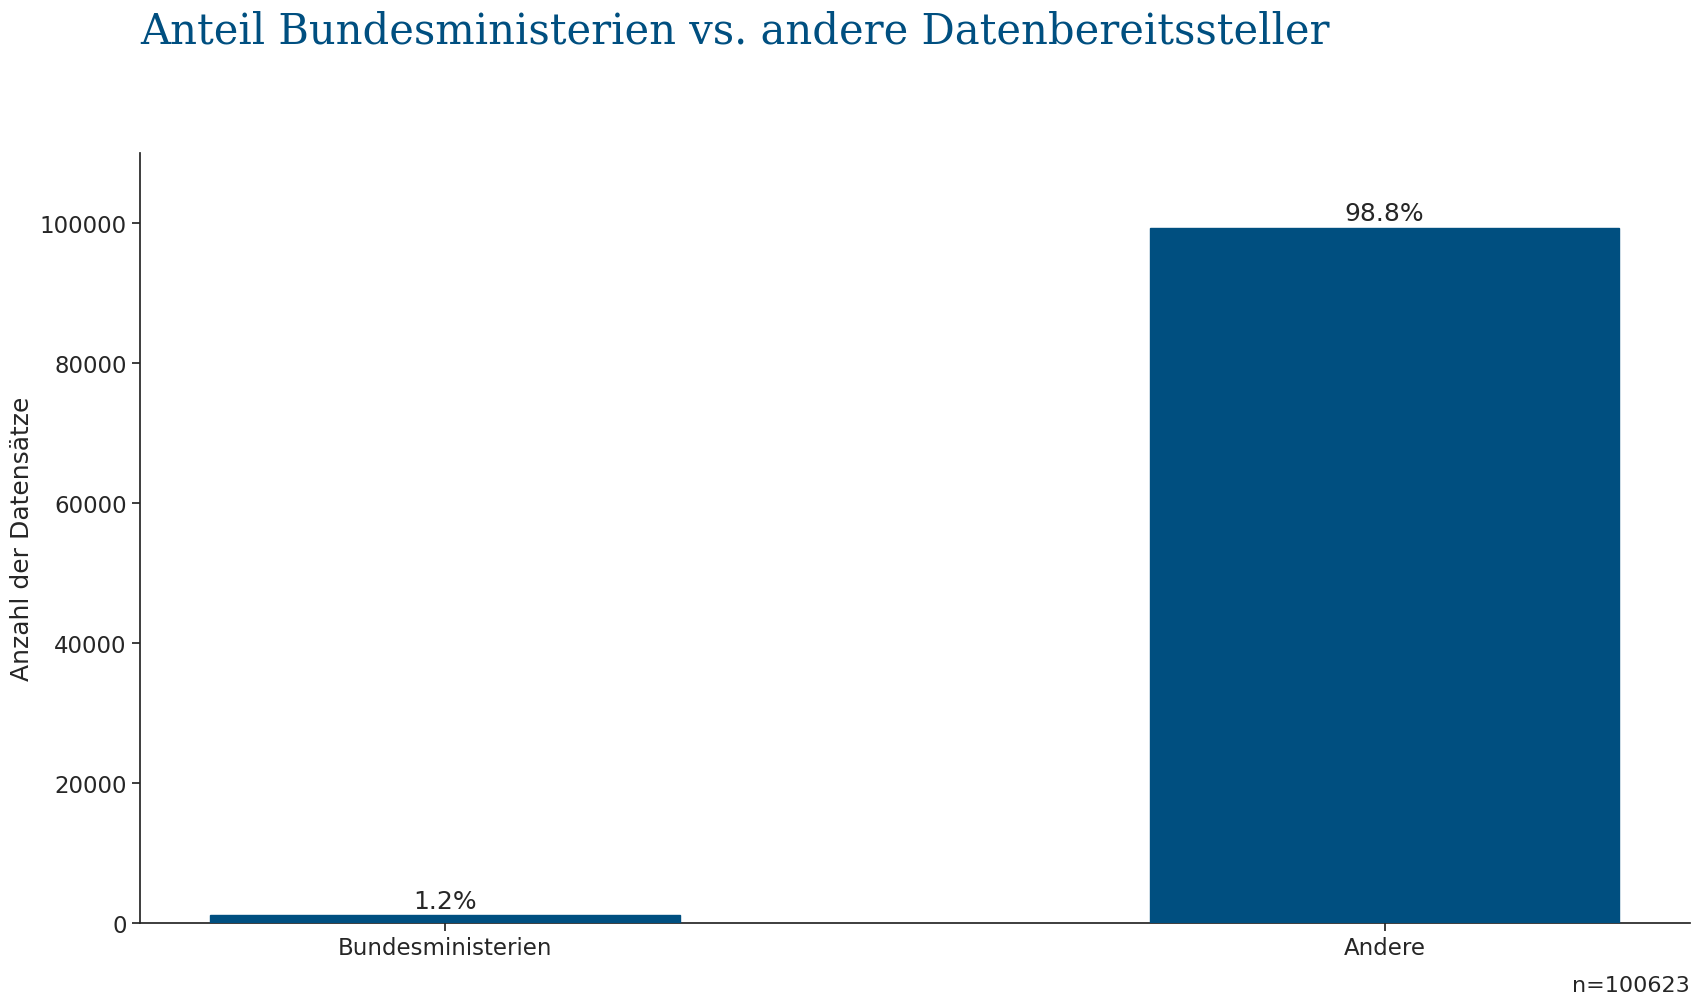

In [70]:
# Bar chart of n_datasets_all and n_datasets_bm

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params, font_scale=1.5)

# Create the figure
fig, ax = plt.subplots(figsize=(20,10))

# set font properties and position of title 
title_font = {'size': 30, 'family': 'serif', 'color': '#004F80'}
ax.set_title("Anteil Bundesministerien vs. andere Datenbereitssteller", fontdict=title_font, loc='left', pad=80)


# Add caption below the plot with n=n_datasets_all+n_datasets_bm
caption = 'n=' + str(n_datasets_all+n_datasets_bm)
ax.text(1, -0.08, caption, ha='right', va='center', transform=ax.transAxes, fontsize=16)

# Set subtitle
#ax.text(0.5, 0.97, 'Bundesministerien (' + str(n_datasets_bm) + ') vs Andere (' + str(n_datasets_all) + ')', ha='center', va='center', transform=ax.transAxes)

# Set the labels
ax.set_xlabel('')
ax.set_ylabel('Anzahl der Datensätze')

# Set the x-axis labels to horizontal
ax.tick_params(axis='x', labelrotation=0)

# Set the x-axis labels
ax.set_xticks([0, 1])
ax.set_xticklabels(['Bundesministerien', 'Andere'])

# Set ylimit
ax.set_ylim(0, 110000)

# Set the y-axis labels
ax.set_yticks(np.arange(0, 100001, 20000))
ax.set_yticklabels(np.arange(0, 100001, 20000))

# Set the bar width
bar_width = 0.5

# Plot the bars
ax.bar(0, n_datasets_bm, width=bar_width, color='#004F80', edgecolor='#004F80', zorder=3)
ax.bar(1, n_datasets_all, width=bar_width, color='#004F80', edgecolor='#004F80', zorder=3)

# Add the percentages
ax.annotate('{:.1f}%'.format(percentage_bm), (0, n_datasets_bm), ha='center', va='center', xytext=(0, 10), textcoords='offset points')
ax.annotate('{:.1f}%'.format(100 - percentage_bm), (1, n_datasets_all), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

# Save plot as PNG
plt.savefig(f'output/{datetime.now().strftime("%Y%m%d")}_BM_vs_andere.png', bbox_inches='tight', dpi=300)

# Show the plot
plt.show()


In [71]:
# Subset the file format from the distribution_link column
df['file_format'] = df['distribution_link'].str.split('.').str[-1]

# Change all values in file_column to 'csv' that contain '.csv' and all to 'json' that contain '.json'
df.loc[df['distribution_link'].str.contains('csv', case=False), 'file_format'] = 'csv'
df.loc[df['distribution_link'].str.contains('json', case=False), 'file_format'] = 'json'
df.loc[df['distribution_link'].str.contains('pdf', case=False), 'file_format'] = 'pdf'
df.loc[df['distribution_link'].str.contains('xlsx', case=False), 'file_format'] = 'xlsx'
df.loc[df['distribution_link'].str.contains('xls[^x]', case=False), 'file_format'] = 'xls'
df.loc[df['distribution_link'].str.contains('xlm', case=False), 'file_format'] = 'xlm'

# Change all values in file_column to 'other' that are longer than 4 characters
df.loc[df['file_format'].str.len() > 5, 'file_format'] = 'other link'

# Change all values in file_column to 'other' that are "html"
df.loc[df['file_format'] == 'html', 'file_format'] = 'other link'

# Count number of occurences and change all to 'other' that occur fewer than 5 times
df['file_format'] = df['file_format'].where(df['file_format'].map(df['file_format'].value_counts()) > 5, 'other link')

# Export df to CSV
#df.to_csv('output/govdata.csv', index=False)

In [72]:
# Count number of occurences in file_format 
df_file_format = df['file_format'].value_counts()

print(df_file_format)

file_format
other link    1084
csv            515
pdf            405
xls            349
xml            168
xlsx            73
zip             12
txt              7
json             6
Name: count, dtype: int64


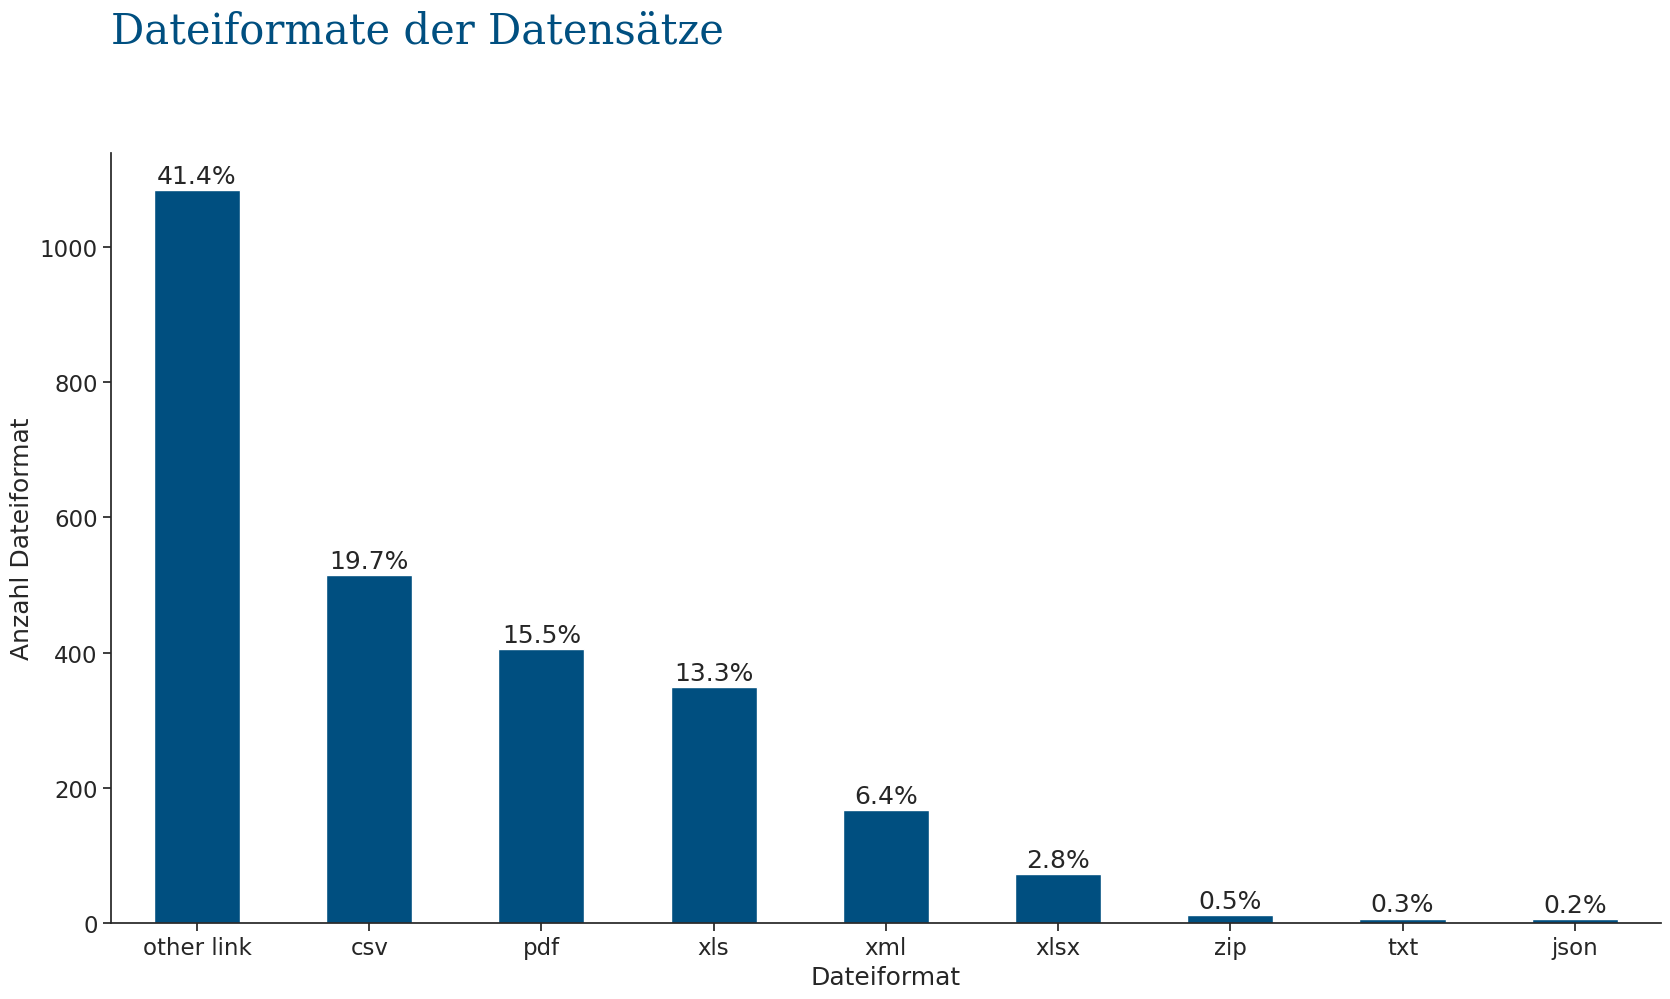

In [73]:
# Plot df_file_format

# Set the font scale
sns.set(font_scale=1.5)

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params, font_scale=1.5)

# Set the color palette
sns.set_palette("bright")

# Create the plot
ax = df_file_format.plot(kind='bar', figsize=(20,10), color = "#004F80")

# set font properties and position of title 
title_font = {'size': 30, 'family': 'serif', 'color': '#004F80'}
ax.set_title("Dateiformate der Datensätze", fontdict=title_font, loc='left', pad=80)


# Set the labels
ax.set_xlabel('Dateiformat')
ax.set_ylabel('Anzahl Dateiformat')

# Set the x-axis labels to horizontal
ax.tick_params(axis='x', labelrotation=0)

# Add the percentages
for p in ax.patches:
    ax.annotate('{:.1f}%'.format(100 * p.get_height() / df_file_format.sum()), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

# Save plot as PNG
plt.savefig(f'output/{datetime.now().strftime("%Y%m%d")}_Dateiformate_BM.png', bbox_inches='tight', dpi=300)

# Show the plot
plt.show()


In [74]:
# Count the number of datasets per publisher and publication_year
df_year_publisher = df_distinct.groupby(['publisher_short', 'publication_year']).size().reset_index(name='n_datasets')

# Change publication_year to integer
df_year_publisher['publication_year'] = df_year_publisher['publication_year'].astype(int)

# Sort the values by publication_year
df_year_publisher = df_year_publisher.sort_values(by=['publication_year'])

# Change the index to publication_year
#df_year_publisher = df_year_publisher.set_index('publication_year')

print(df_year_publisher)

    publisher_short  publication_year  n_datasets
0              BMWK              2009           0
105            BMEL              2009           0
60              BMJ              2009           0
45               AA              2009           0
180            BMBF              2009           0
..              ...               ...         ...
44              BMI              2023           0
29              BMF              2023           3
14             BMWK              2023           0
224           BMWSB              2023           0
239           BKAmt              2023           0

[240 rows x 3 columns]


In [75]:
# Count the number of datasets per year
df_distinct_year = df_distinct['publication_year'].value_counts()

# Rename the column
#df_distinct_year = df_distinct_year.rename_axis('year').reset_index(name='count')

# Set the index to the year
#df_distinct_year = df_distinct_year.set_index('year')

# Change year to integer
df_distinct_year.index = df_distinct_year.index.astype(int)

# Change year to datetime
# df_distinct_year.index = pd.to_datetime(df_distinct_year.index, format='%Y')

# Sort the index
df_distinct_year = df_distinct_year.sort_index()

# Print the result
print(df_distinct_year)

publication_year
2009     2
2010     2
2011     1
2012     1
2013     2
2014     7
2015    22
2016     3
2017     6
2018    23
2019    90
2020    44
2021    35
2022    19
2023     7
Name: count, dtype: int64


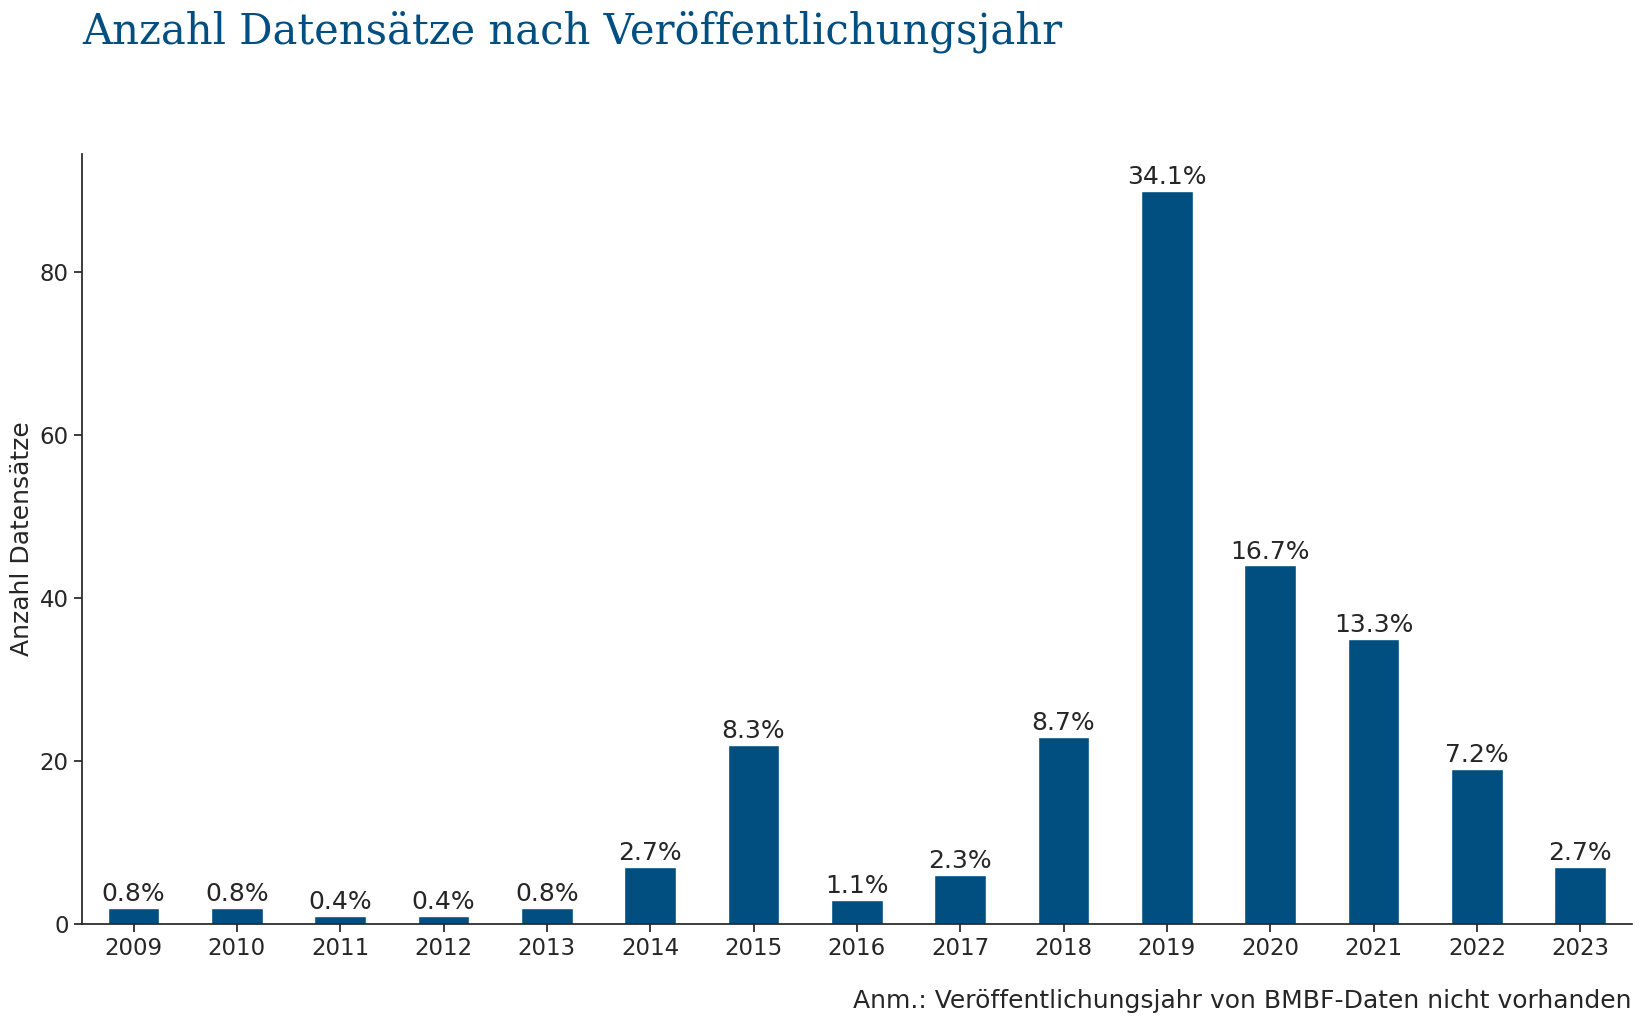

In [76]:
# Plot df_distinct_year

# Set the font scale
sns.set(font_scale=1.5)

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params, font_scale=1.5)

# Set the color palette
sns.set_palette("bright")


# Create the plot
ax = df_distinct_year.plot(kind='bar', figsize=(20,10), color = '#004F80')

# set font properties and position of title 
title_font = {'size': 30, 'family': 'serif', 'color': '#004F80'}
ax.set_title("Anzahl Datensätze nach Veröffentlichungsjahr", fontdict=title_font, loc='left', pad=80)



# Set the labels
ax.set_xlabel('')
ax.set_ylabel('Anzahl Datensätze')

# Set the x-axis labels to horizontal
ax.tick_params(axis='x', labelrotation=0)

# Add the percentages
for p in ax.patches:
    ax.annotate('{:.1f}%'.format(100 * p.get_height() / df_distinct_year.sum()), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

# Add caption
ax.text(1, -0.1, 'Anm.: Veröffentlichungsjahr von BMBF-Daten nicht vorhanden', ha='right', va='center', transform=ax.transAxes)

# Add annotation for 2019 in color black with Text "Größe OD-Aktivitäten"
#ax.annotate('Größte OD-Aktivitäten', xy=(10, 70), xytext=(5, 80), xycoords='data', textcoords='data', arrowprops=dict(arrowstyle="->", connectionstyle="arc3", color = 'black'), color='black')

# Save plot as PNG
plt.savefig(f'output/{datetime.now().strftime("%Y%m%d")}_Jahr_BM.png', bbox_inches='tight', dpi=300)

# Show the plot
plt.show()


In [77]:
random_rows = df.sample(n=30)

In [78]:
""" import requests

# List of URLs to check
# urls = random_rows.distribution_link
urls = df.distribution_link
# Create a list of dictionaries to store the results
results = []

# Check the status of each URL and store the result in the list of dictionaries
for url in urls:
    try:
        response = requests.get(url)
        if response.status_code == 200:
            status = "OK"
        else:
            status = f"Error {response.status_code}"
    except requests.exceptions.RequestException as e:
        status = f"Error {e}"
    results.append({"url": url, "status": status})

# Create a DataFrame from the list of dictionaries
results_url_status = pd.DataFrame(results)

# Save the DataFrame to a CSV file
results_url_status.to_csv("output/results_url_status.csv", index=False)

# Print the DataFrame
print(results_url_status)

# Delete variables that are not needed anymore
del results, response, url, urls """

' import requests\n\n# List of URLs to check\n# urls = random_rows.distribution_link\nurls = df.distribution_link\n# Create a list of dictionaries to store the results\nresults = []\n\n# Check the status of each URL and store the result in the list of dictionaries\nfor url in urls:\n    try:\n        response = requests.get(url)\n        if response.status_code == 200:\n            status = "OK"\n        else:\n            status = f"Error {response.status_code}"\n    except requests.exceptions.RequestException as e:\n        status = f"Error {e}"\n    results.append({"url": url, "status": status})\n\n# Create a DataFrame from the list of dictionaries\nresults_url_status = pd.DataFrame(results)\n\n# Save the DataFrame to a CSV file\nresults_url_status.to_csv("output/results_url_status.csv", index=False)\n\n# Print the DataFrame\nprint(results_url_status)\n\n# Delete variables that are not needed anymore\ndel results, response, url, urls '

In [79]:
# Save the df results_url_status to a CSV file with actual date in the filename

#from datetime import datetime
#results_url_status.to_csv(f"output/results_url_status_{datetime.now().strftime('%Y%m%d')}.csv", index=False)

In [80]:
# Save the results_url_status to a CSV file
#results_url_status.to_csv("output/results_url_status.csv", index=False)

In [81]:
# Load the results_url_status from a CSV file
results_url_status = pd.read_csv("output/results_url_status.csv")

(results_url_status["status"] == "OK").sum()

2474

In [82]:
# Change status to Error if the status is not OK
results_url_status.loc[results_url_status["status"] != "OK", "status"] = "Error"

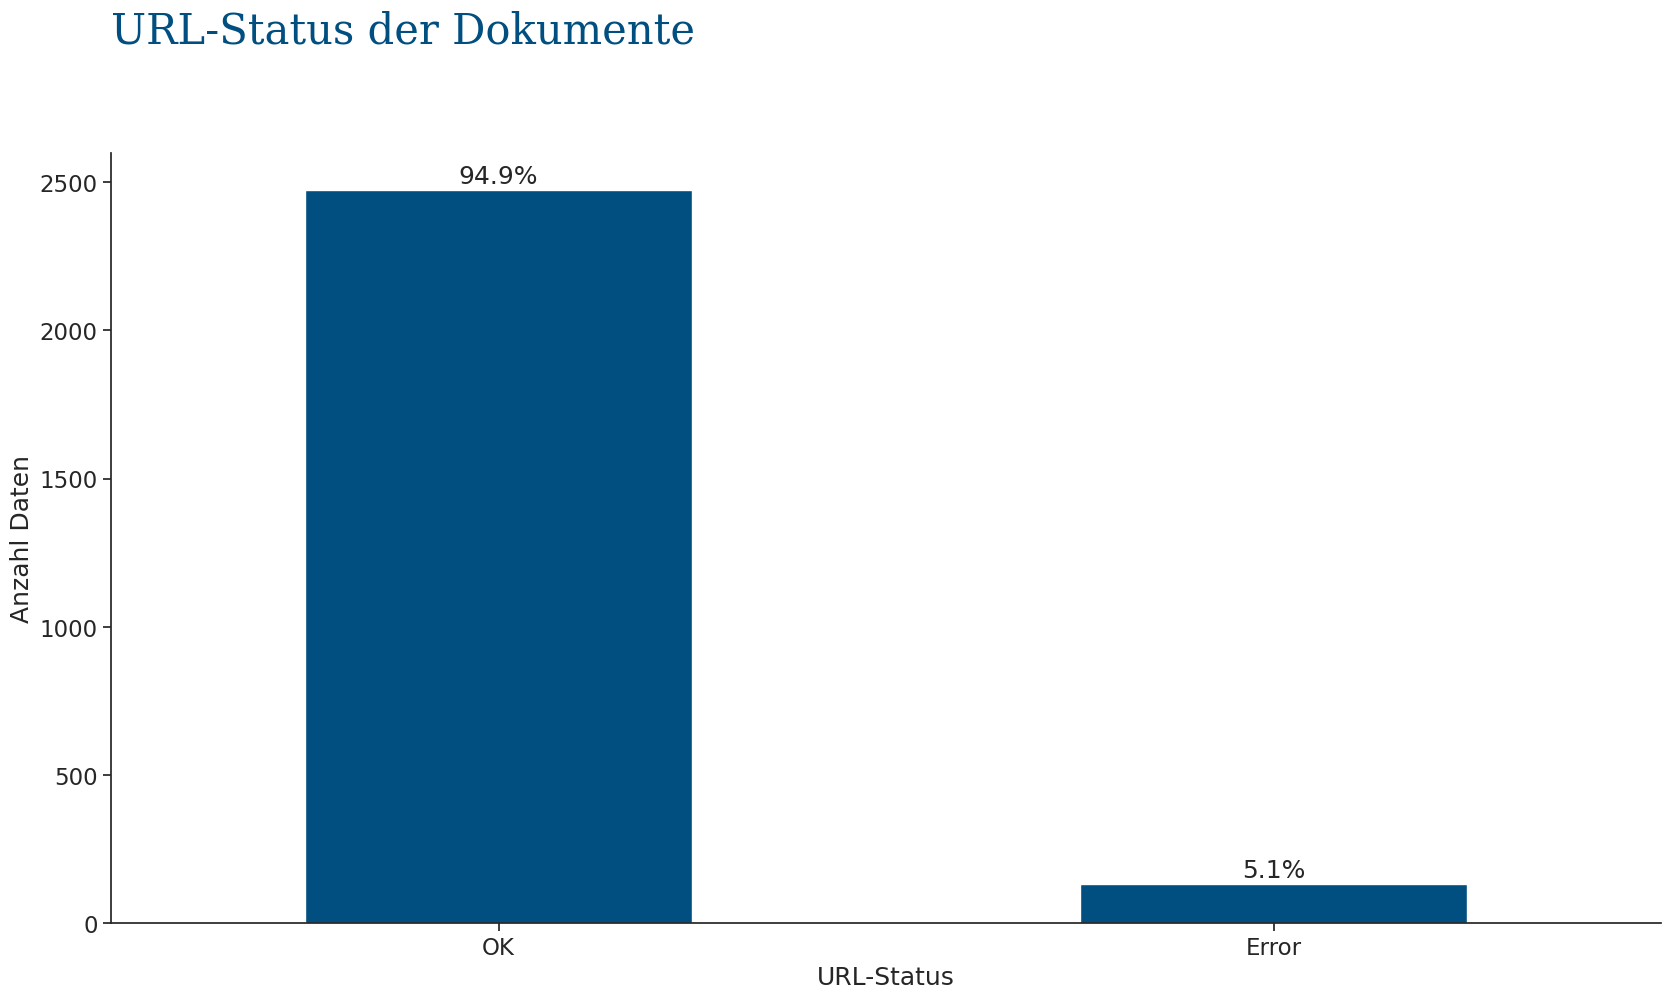

In [83]:
# Plot results_url_status with Seaborn

# Set the font scale
sns.set(font_scale=1.5)

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params, font_scale=1.5)

# Set the color palette
sns.set_palette("bright")
# Create the plot
ax = results_url_status['status'].value_counts().plot(kind='bar', figsize=(20,10), color = "#004F80")

# set font properties and position of title 
title_font = {'size': 30, 'family': 'serif', 'color': '#004F80'}
ax.set_title("URL-Status der Dokumente", fontdict=title_font, loc='left', pad=80)


# Set the labels
ax.set_xlabel('URL-Status')
ax.set_ylabel('Anzahl Daten')

# Set the x-axis labels to horizontal
ax.tick_params(axis='x', labelrotation=0)

# Add the percentages
for p in ax.patches:
    ax.annotate('{:.1f}%'.format(100 * p.get_height() / results_url_status['status'].value_counts().sum()), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

# Save plot as PNG with todays date in the filename

plt.savefig(f'output/{datetime.now().strftime("%Y%m%d")}_URL_Status_BM.png', bbox_inches='tight', dpi=300)
#plt.savefig('output/URL_Status_BM.png', bbox_inches='tight', dpi=300)

# Show the plot
plt.show()


In [84]:
df_license = df_distinct

In [85]:


# From column license get only text ofter '/licenses/'
df_license['license'] = df_license['license'].str.split('/licenses/').str[1]

# From column license get only text before '/'
df_license['license'] = df_license['license'].str.split('/').str[0]

# In column license change 'officalWork' to 'official-work'
df_license['license'] = df_license['license'].str.replace('officalWork', 'official-work')


/tmp/ipykernel_2792/3913743940.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_license['license'] = df_license['license'].str.split('/licenses/').str[1]
/tmp/ipykernel_2792/3913743940.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_license['license'] = df_license['license'].str.split('/').str[0]
/tmp/ipykernel_2792/3913743940.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats

In [86]:
# Count column license
df_license = df_license['license'].value_counts()
print(df_license) 

license
dl-by-de         522
geonutz          260
dl-by-nc-de       79
officialWork      21
other-open        16
cc-by              7
dl-zero-de         7
official-work      4
cc-by-nd           3
cc-by-sa-de        2
cc-by-de           1
Name: count, dtype: int64


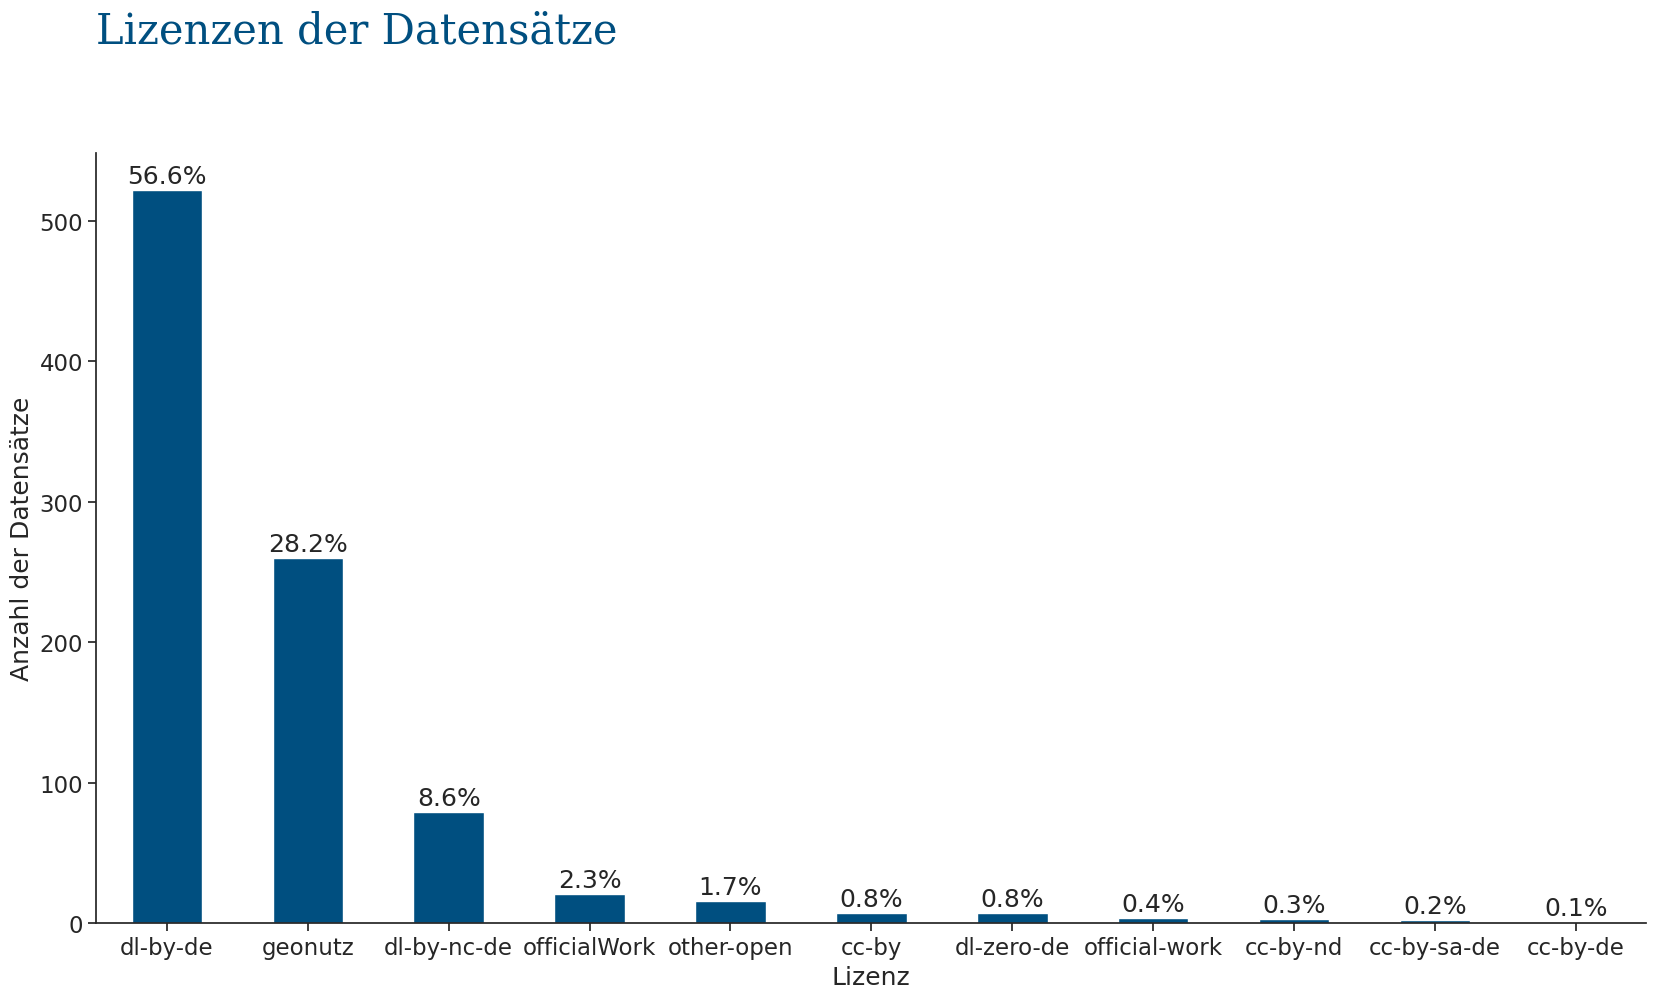

In [87]:
# Plot df_license with Seaborn

# Set the font scale
sns.set(font_scale=1.5)

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params, font_scale=1.5)

# Set the color palette
sns.set_palette("bright")

# Create the plot
ax = df_license.plot(kind='bar', figsize=(20,10), color = "#004F80")

# set font properties and position of title
title_font = {'size': 30, 'family': 'serif', 'color': '#004F80'}
ax.set_title("Lizenzen der Datensätze", fontdict=title_font, loc='left', pad=80)

# Set the labels
ax.set_xlabel('Lizenz')
ax.set_ylabel('Anzahl der Datensätze')

# Set the x-axis labels to horizontal
ax.tick_params(axis='x', labelrotation=0)

# Add the percentages
for p in ax.patches:
    ax.annotate('{:.1f}%'.format(100 * p.get_height() / df_license.sum()), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

# Save plot as PNG
plt.savefig(f'output/{datetime.now().strftime("%Y%m%d")}_Lizenzen_BM.png', bbox_inches='tight', dpi=300)

# Show the plot
plt.show()

